[数据集定义与加载-使用文档-PaddlePaddle深度学习平台](https://www.paddlepaddle.org.cn/documentation/docs/zh/guides/beginner/data_load_cn.html)

In [1]:
import paddle
print('计算机视觉（CV）相关数据集：', paddle.vision.datasets.__all__)
print('自然语言处理（NLP）相关数据集：', paddle.text.__all__)


计算机视觉（CV）相关数据集： ['DatasetFolder', 'ImageFolder', 'MNIST', 'FashionMNIST', 'Flowers', 'Cifar10', 'Cifar100', 'VOC2012']
自然语言处理（NLP）相关数据集： ['Conll05st', 'Imdb', 'Imikolov', 'Movielens', 'UCIHousing', 'WMT14', 'WMT16']


In [2]:
from paddle.vision.transforms import Normalize

# 定义图像归一化处理方法，这里的CHW指图像格式需为 [C通道数，H图像高度，W图像宽度]
transform = Normalize(mean=[127.5], std=[127.5], data_format='CHW')
# 下载数据集并初始化 DataSet
train_dataset = paddle.vision.datasets.MNIST(mode='train', transform=transform)
test_dataset = paddle.vision.datasets.MNIST(mode='test', transform=transform)
print('train images: ',len(train_dataset),', test images: ',len(test_dataset))


Cache file C:\Users\ljc\.cache\paddle\dataset\mnist\train-images-idx3-ubyte.gz not found, downloading https://dataset.bj.bcebos.com/mnist/train-images-idx3-ubyte.gz 
Begin to download

Download finished
Cache file C:\Users\ljc\.cache\paddle\dataset\mnist\train-labels-idx1-ubyte.gz not found, downloading https://dataset.bj.bcebos.com/mnist/train-labels-idx1-ubyte.gz 
Begin to download
........
Download finished
Cache file C:\Users\ljc\.cache\paddle\dataset\mnist\t10k-images-idx3-ubyte.gz not found, downloading https://dataset.bj.bcebos.com/mnist/t10k-images-idx3-ubyte.gz 
Begin to download

Download finished
Cache file C:\Users\ljc\.cache\paddle\dataset\mnist\t10k-labels-idx1-ubyte.gz not found, downloading https://dataset.bj.bcebos.com/mnist/t10k-labels-idx1-ubyte.gz 
Begin to download
..
Download finished


train images:  60000 , test images:  10000


shape of image:  (1, 28, 28)


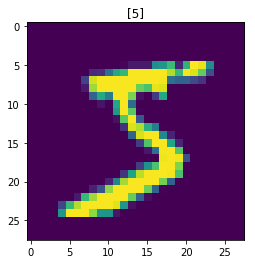

In [4]:
from matplotlib import pyplot as plt

for data in train_dataset:
    image, label = data
    print('shape of image: ',image.shape)
    plt.title(str(label))
    plt.imshow(image[0])
    break


# 自定义dataset

In [5]:
import os
import cv2
import numpy as np
from paddle.io import Dataset

class MyDataset(Dataset):
    """
    步骤一：继承 paddle.io.Dataset 类
    """
    def __init__(self, data_dir, label_path, transform=None):
        """
        步骤二：实现 __init__ 函数，初始化数据集，将样本和标签映射到列表中
        """
        super(MyDataset, self).__init__()
        self.data_list = []
        with open(label_path,encoding='utf-8') as f:
            for line in f.readlines():
                image_path, label = line.strip().split('\t')
                image_path = os.path.join(data_dir, image_path)
                self.data_list.append([image_path, label])
        # 传入定义好的数据处理方法，作为自定义数据集类的一个属性
        self.transform = transform

    def __getitem__(self, index):
        """
        步骤三：实现 __getitem__ 函数，定义指定 index 时如何获取数据，并返回单条数据（样本数据、对应的标签）
        """
        # 根据索引，从列表中取出一个图像
        image_path, label = self.data_list[index]
        # 读取灰度图
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        # 飞桨训练时内部数据格式默认为float32，将图像数据格式转换为 float32
        image = image.astype('float32')
        # 应用数据处理方法到图像上
        if self.transform is not None:
            image = self.transform(image)
        # CrossEntropyLoss要求label格式为int，将Label格式转换为 int
        label = int(label)
        # 返回图像和对应标签
        return image, label

    def __len__(self):
        """
        步骤四：实现 __len__ 函数，返回数据集的样本总数
        """
        return len(self.data_list)

# 定义图像归一化处理方法，这里的CHW指图像格式需为 [C通道数，H图像高度，W图像宽度]
transform = Normalize(mean=[127.5], std=[127.5], data_format='CHW')
# 打印数据集样本数
train_custom_dataset = MyDataset('mnist/train','mnist/train/label.txt', transform)
test_custom_dataset = MyDataset('mnist/val','mnist/val/label.txt', transform)
print('train_custom_dataset images: ',len(train_custom_dataset), 'test_custom_dataset images: ',len(test_custom_dataset))


FileNotFoundError: [Errno 2] No such file or directory: 'mnist/train/label.txt'

In [ ]:
for data in train_custom_dataset:
    image, label = data
    print('shape of image: ',image.shape)
    plt.title(str(label))
    plt.imshow(image[0])
    break

# 使用 paddle.io.DataLoader 定义数据读取器
通过前面介绍的直接迭代读取 Dataset 的方式虽然可实现对数据集的访问，但是这种访问方式只能单线程进行并且还需要手动分批次（batch）。在飞桨框架中，推荐使用 paddle.io.DataLoader API 对数据集进行多进程的读取，并且可自动完成划分 batch 的工作

In [ ]:
# 定义并初始化数据读取器
train_loader = paddle.io.DataLoader(train_custom_dataset, batch_size=64, shuffle=True, num_workers=1, drop_last=True)

# 调用 DataLoader 迭代读取数据
for batch_id, data in enumerate(train_loader()):
    images, labels = data
    print("batch_id: {}, 训练数据shape: {}, 标签数据shape: {}".format(batch_id, images.shape, labels.shape))
    break


#（可选）自定义采样器
采样器定义了从数据集中的采样行为，如顺序采样、批次采样、随机采样、分布式采样等。采样器会根据设定的采样规则，返回数据集中的索引列表，然后数据读取器 Dataloader 即可根据索引列表从数据集中取出对应的样本。

飞桨框架在 paddle.io 目录下提供了多种采样器，如批采样器 BatchSampler、分布式批采样器 DistributedBatchSampler、顺序采样器 SequenceSampler、随机采样器 RandomSampler 等。

下面通过两段示例代码，介绍采样器的用法。

首先，以 BatchSampler 为例，介绍在 DataLoader 中使用 BatchSampler 获取采样数据的方法。

In [ ]:
from paddle.io import BatchSampler

# 定义一个批采样器，并设置采样的数据集源、采样批大小、是否乱序等
bs = BatchSampler(train_custom_dataset, batch_size=8, shuffle=True, drop_last=True)

print("BatchSampler 每轮迭代返回一个索引列表")
for batch_indices in bs:
    print(batch_indices)
    break

# 在 DataLoader 中使用 BatchSampler 获取采样数据
train_loader = paddle.io.DataLoader(train_custom_dataset, batch_sampler=bs, num_workers=1)

print("在 DataLoader 中使用 BatchSampler，返回索引对应的一组样本和标签数据 ")
for batch_id, data in enumerate(train_loader()):
    images, labels = data
    print("batch_id: {}, 训练数据shape: {}, 标签数据shape: {}".format(batch_id, images.shape, labels.shape))
    break


BatchSampler 每轮迭代返回一个索引列表
[53486, 39208, 42267, 46762, 33087, 54705, 55986, 20736]
在 DataLoader 中使用 BatchSampler，返回索引对应的一组样本和标签数据
batch_id: 0, 训练数据shape: [8, 1, 28, 28], 标签数据shape: [8]

In [6]:
from paddle.io import SequenceSampler, RandomSampler, BatchSampler, DistributedBatchSampler

class RandomDataset(paddle.io.Dataset):
    def __init__(self, num_samples):
        self.num_samples = num_samples

    def __getitem__(self, idx):
        image = np.random.random([784]).astype('float32')
        label = np.random.randint(0, 9, (1, )).astype('int64')
        return image, label

    def __len__(self):
        return self.num_samples

train_dataset = RandomDataset(100)

print('-----------------顺序采样----------------')
sampler = SequenceSampler(train_dataset)
batch_sampler = BatchSampler(sampler=sampler, batch_size=10)

for index in batch_sampler:
    print(index)

print('-----------------随机采样----------------')
sampler = RandomSampler(train_dataset)
batch_sampler = BatchSampler(sampler=sampler, batch_size=10)

for index in batch_sampler:
    print(index)

print('-----------------分布式采样----------------')
batch_sampler = DistributedBatchSampler(train_dataset, num_replicas=2, batch_size=10)

for index in batch_sampler:
    print(index)


-----------------顺序采样----------------
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
[20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
[30, 31, 32, 33, 34, 35, 36, 37, 38, 39]
[40, 41, 42, 43, 44, 45, 46, 47, 48, 49]
[50, 51, 52, 53, 54, 55, 56, 57, 58, 59]
[60, 61, 62, 63, 64, 65, 66, 67, 68, 69]
[70, 71, 72, 73, 74, 75, 76, 77, 78, 79]
[80, 81, 82, 83, 84, 85, 86, 87, 88, 89]
[90, 91, 92, 93, 94, 95, 96, 97, 98, 99]
-----------------随机采样----------------
[57, 63, 80, 41, 49, 6, 35, 79, 10, 56]
[77, 96, 33, 68, 98, 64, 53, 73, 47, 8]
[15, 76, 27, 38, 4, 87, 71, 78, 37, 11]
[30, 34, 1, 58, 65, 29, 81, 55, 7, 21]
[97, 83, 69, 3, 22, 84, 26, 45, 62, 86]
[19, 72, 17, 12, 14, 20, 95, 54, 2, 67]
[18, 0, 91, 36, 52, 24, 70, 28, 50, 13]
[85, 46, 74, 92, 16, 82, 88, 99, 48, 31]
[51, 5, 90, 59, 60, 39, 66, 40, 23, 61]
[94, 75, 44, 42, 25, 93, 43, 89, 9, 32]
-----------------分布式采样----------------
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
[40, 41, 42, 

从代码输出结果可以看出：

顺序采样：按照顺序的方式输出各个样本的索引。

随机采样：先将样本顺序打乱，再输出乱序后的样本索引。

分布式采样：常用于分布式训练场景，将样本数据切分成多份，分别放到不同卡上训练。示例中设置了 num_replicas=2，样本会被划分到两张卡上，所以这里只输出一半样本的索引。